In [1]:
import pandas as pd
from numpy import random

from consts import default_random_seed
from sample_generation import create_sample
from strata import Strata
from zhang_rubin_help_func import calc_non_parametric_zhang_rubin, calc_zhang_rubin_bounds, plot_zhang_rubin_bounds

random.seed(default_random_seed)

# $Y(t)|X,S_t=1$


In [2]:
# sample_for_y_dist = create_sample(
#     y0_dist_param ={'a0': 0.0, 'b0': 2.0, 'c0': 100.0, 'sigma_01': 1, 'sigma_00': 1} , 
#     y1_dist_param = {'a1': 0.0, 'b1': 4.0, 'c1': 100.0, 'sigma_11': 1, 'sigma_10': 1})

sample_for_y_dist = create_sample()
print("\nExample from each strata:")
sample_for_y_dist.groupby("stratum").sample(n=3, random_state=1)


Example from each strata:


,x,t,D0,D1,stratum,S1,S0,Y0,Y1,D_obs,...,mu0,mu1,sigma_0,sigma_1,a0,b0,c0,a1,b1,c1
7918,-0.772476,0,0,0,AS,1.0,1.0,10.023207,6.979855,0,...,8.455048,6.910096,1,1,0.0,2.0,10.0,0.0,4.0,10.0
4441,0.661246,0,0,0,AS,1.0,1.0,11.454635,14.160109,0,...,11.322491,12.644982,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7416,-0.390478,1,0,0,AS,1.0,1.0,10.409915,8.540856,0,...,9.219044,8.438087,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3417,0.308684,1,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9948,0.022873,0,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
5502,-0.534283,0,1,1,D,NaN,NaN,NaN,NaN,1,...,NaN,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
1133,-0.559634,1,0,1,H,NaN,0.0,-0.318115,NaN,1,...,-1.119267,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
3691,0.049471,0,0,1,H,NaN,0.0,-0.175954,NaN,0,...,0.098943,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
9260,-0.092492,0,0,1,H,NaN,0.0,0.499586,NaN,0,...,-0.184985,NaN,1,1,0.0,2.0,10.0,0.0,4.0,10.0
7049,-0.025835,0,1,0,P,0.0,NaN,NaN,0.104010,1,...,NaN,-0.103340,1,1,0.0,2.0,10.0,0.0,4.0,10.0


## Using observational data:

1.   Zhang & Rubin
2.   Using the parametric assumptions - Y is normal, estimate mu out of two mixed gaussians that differ by one latent variable

### 1. Zhang & Rubin

#### Non parametric

In [3]:
zhang_rubin_lb, zhang_rubin_ub = calc_non_parametric_zhang_rubin(sample_for_y_dist)
print(f"Bounds by Zhang and Rubin: [{zhang_rubin_lb}, {zhang_rubin_ub}]")
as_df = sample_for_y_dist.loc[sample_for_y_dist.stratum==Strata.AS.name]
print(f"Actual AS treatment effect: {(as_df.Y1-as_df.Y0).mean()}")

Bounds by Zhang and Rubin: [-1.963831565780759, 0.2792491148288061]
Actual AS treatment effect: -0.09352604936304877


#### Parametric

$\Rightarrow\bar{Y}^{obs}(1)_{\left[0,\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot
\int_{\frac{\Phi_{Y_{(1)}}^{-1}(0)-\mu^P_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^P_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}
(y\cdot\sigma_{Y_{(1)}}+\mu^P_{Y_{(1)}})\cdot\varphi(y)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot
  \int_{\frac{\Phi_{Y_{(1)}}^{-1}(0)-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi_{Y_{(1)}}^{-1}\left(\frac{P_{T=0,D=0}}{P_{T=1,D=0}}-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}
(y\cdot\sigma_{Y_{(1)}}+\mu^{AS}_{Y_{(1)}})\cdot\varphi(y)\,\cdot dy$

<br>

$\Rightarrow\bar{Y}^{obs}(1)_{\left[1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}},1\right]} \rightarrow
\frac{\pi_P}{\pi_{P}+\pi_{AS}}\cdot
\int_{\frac{\Phi_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^P_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi_{Y_{(1)}}^{-1}(1)-\mu^P_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}
(y\cdot\sigma_{Y_{(1)}}+\mu^P_{Y_{(1)}})\cdot\varphi(y)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{P}+\pi_{AS}}\cdot
  \int_{\frac{\Phi_{Y_{(1)}}^{-1}\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}^{\frac{\Phi_{Y_{(1)}}^{-1}(1)-\mu^{AS}_{Y_{(1)}}}{\sigma_{Y_{(1)}}}}
(y\cdot\sigma_{Y_{(1)}}+\mu^{AS}_{Y_{(1)}})\cdot\varphi(y)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[\frac{\pi_h}{P_{T=1,D=0}},1\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot
\int_{\frac{\Phi_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^H_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi_{Y_{(0)}}^{-1}(1)-\mu^H_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}
(y\cdot\sigma_{Y_{(0)}}+\mu^H_{Y_{(0)}})\cdot\varphi(y)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot
  \int_{\frac{\Phi_{Y_{(0)}}^{-1}\left(\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi_{Y_{(0)}}^{-1}(1)-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}
(y\cdot\sigma_{Y_{(0)}}+\mu^{AS}_{Y_{(0)}})\cdot\varphi(y)\,\cdot dy$
<br>
$\Rightarrow\bar{Y}^{obs}(0)_{\left[0,1-\frac{\pi_h}{P_{T=1,D=0}}\right]} \rightarrow
\frac{\pi_H}{\pi_{H}+\pi_{AS}}\cdot
\int_{\frac{\Phi_{Y_{(0)}}^{-1}\left(0\right)-\mu^H_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^H_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}
(y\cdot\sigma_{Y_{(0)}}+\mu^H_{Y_{(0)}})\cdot\varphi(y)\,\cdot dy
  + \frac{\pi_{AS}}{\pi_{H}+\pi_{AS}}\cdot
  \int_{\frac{\Phi_{Y_{(0)}}^{-1}\left(0\right)-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}^{\frac{\Phi_{Y_{(0)}}^{-1}\left(1-\frac{\pi_h}{P_{T=1,D=0}}\right)-\mu^{AS}_{Y_{(0)}}}{\sigma_{Y_{(0)}}}}
(y\cdot\sigma_{Y_{(0)}}+\mu^{AS}_{Y_{(0)}})\cdot\varphi(y)\,\cdot dy$

Note that the weights are identifiable from observational data:
$\frac{\pi_{P}}{\pi_{P}+\pi_{AS}}=\left(1-\frac{P_{T=0,D=0}}{P_{T=1,D=0}}+\frac{\pi_h}{P_{T=1,D=0}}\right)$ <br>
$\frac{\pi_{H}}{\pi_{H}+\pi_{AS}}=\left(\frac{\pi_h}{P_{T=0,D=0}}\right)$

<br>
$\Phi_{Y_{(1)}}^{-1}(\alpha)=P(Y_{(1)}<F^{-1}(\alpha))$ where $F^{-1}(\alpha)$ is the $\alpha$ quantile of $Y_{(1)}$. Although quantile function for mixed Gaussians does not admit a closed-form expression, it can be calculated. First we'll calculate the quantile using binary search, and then we'll calculate the cdf of that quantile.

##### For 40 samples, plot $\pi_h$, parametric bounds for each $\pi_h$, final parametric and non parametric bounds

In [4]:
# pi_h_and_bounds_plots_controller(sample_for_y_dist)

TODO - Note that some pi's don't have the integral solution <br>
TODO - check the $\mu$ inside the integral vs outside, should be the same (for given bounds)<br>

In [5]:
sample_for_y_dist_s = sample_for_y_dist.loc[sample_for_y_dist.D_obs==0]
zhang_rubin_bounds = calc_zhang_rubin_bounds(sample_for_y_dist_s)

row 0 out of 9238


lower bound: (0.004264958003532036, -0.0025439183477406397, 0.015252822072562927, 0.02359513557992309, 3.66786779848432e-05, 3.66489850877399e-05, 0.0009478894977403159, 0.023638137034038633, 0.017876928080547427, -1.8178344576867694e-06, -0.002702920446196737, 0.0035197719984850183, 0.00018595204231054404, 8.212570915238371e-05, 8.599379897395869e-05, 0.0013331323011916572, 0.008834986920181564, 0.0010403581903575224, 0.023724043489545196, 2.0355190476333563e-05, 0.0010590201547035511, 0.0037828307267535645, 0.01130565109215347, 0.008825861067945341, 0.00013571342386173738, 0.01772074284680516, 0.02344723222599297, -1.9203499179920846e-06, 0.02370961445891782, 5.848468765112894e-05, -1.431713202268446e-06, -0.00252201887926226, 0.001342402388640187, 2.1724910516637212e-06, 0.020219125326052533, 0.009646195785656592, 9.81766281140066e-06, 0.015644098379781535, -1.948929006702871e-06, -0.001026612873730693, 0.0005362093634255009, 0.021940495442828944, 0.001529955247006011, 0.01832887959

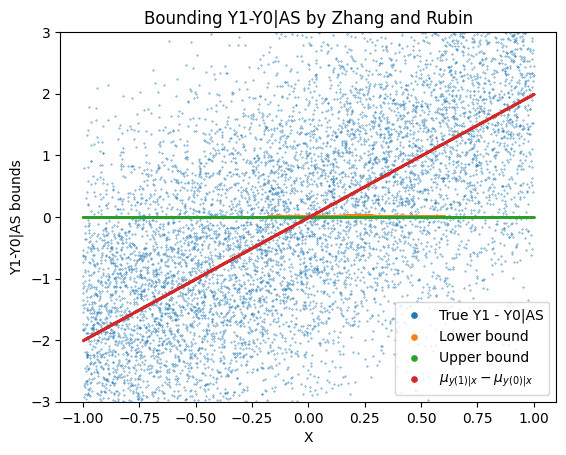

In [6]:
d = plot_zhang_rubin_bounds(sample_for_y_dist_s, zhang_rubin_bounds)

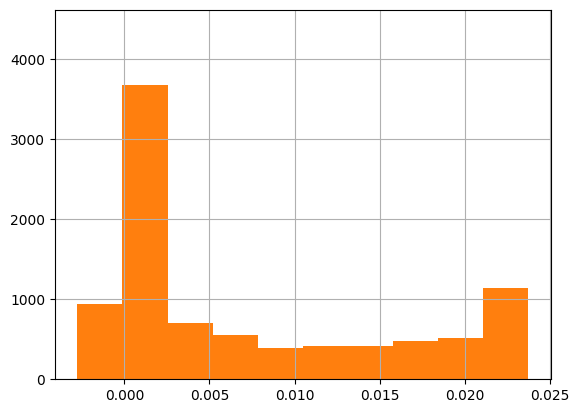

In [7]:
pd.Series(d['up']).hist()
pd.Series(d['lb']).hist()

In [8]:
# check that the bounds are bounding the expected value correctly
for i,true in enumerate(d['true value']):
    if true>d['up'][i] or true<d['lb'][i]:
        print(f"bad {i}")


bad 0
bad 1
bad 2
bad 3
bad 4
bad 5
bad 6
bad 7
bad 8
bad 9
bad 10
bad 11
bad 12
bad 13
bad 14
bad 15
bad 16
bad 17
bad 18
bad 19
bad 20
bad 21
bad 22
bad 23
bad 24
bad 25
bad 26
bad 27
bad 28
bad 29
bad 30
bad 31
bad 32
bad 33
bad 35
bad 36
bad 37
bad 38
bad 39
bad 40
bad 42
bad 43
bad 44
bad 45
bad 46
bad 48
bad 50
bad 51
bad 52
bad 53
bad 54
bad 55
bad 56
bad 57
bad 58
bad 59
bad 60
bad 61
bad 62
bad 63
bad 64
bad 65
bad 66
bad 67
bad 68
bad 69
bad 70
bad 71
bad 72
bad 73
bad 74
bad 75
bad 76
bad 77
bad 78
bad 79
bad 80
bad 81
bad 82
bad 83
bad 84
bad 85
bad 86
bad 87
bad 88
bad 89
bad 90
bad 91
bad 92
bad 93
bad 94
bad 95
bad 96
bad 97
bad 98
bad 99
bad 101
bad 102
bad 103
bad 104
bad 105
bad 106
bad 107
bad 108
bad 109
bad 110
bad 111
bad 112
bad 114
bad 115
bad 116
bad 117
bad 118
bad 119
bad 120
bad 121
bad 122
bad 123
bad 124
bad 125
bad 126
bad 127
bad 128
bad 129
bad 130
bad 131
bad 132
bad 133
bad 134
bad 135
bad 137
bad 138
bad 139
bad 140
bad 141
bad 142
bad 143
bad 144
ba

In [9]:
# d['x']=sample_for_y_dist.x
# pd.DataFrame(d)
# pd.DataFrame(d).lb.min()